# Treino do modelo

In [4]:
import os
import sys

current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

from Functions.Pipeline import pipeline_completa_skus
from Functions.FNC_Pro import lista_produtos, configurar_credenciais_bq,produtos_selecionados

configurar_credenciais_bq(r'G:Drives compartilhados/Bases BI/epoca-230913-b478a9a0dd4c.json')

# --- Caminho para lista personalizada de produtos ---

""" 
Colocar o caminho do arquivo excel (.xlsx) com a lista dos produtos que você deseja treinar

Ex: produtos_selecionado(Documents/Planilhas/Lista_produtos.xlsx)

Depois é só substituir na função abaixo lista_produtos colocando a variável SKUS = lista_selecionados

"""

lista_selecionados = produtos_selecionados('C:/Users/joao.pcarvalho/Desktop/Git Repositórios/Forecast-vendas-e-elasticidade/Lista Produtos/Lista.xlsx')


# --- Definir filtros para os produtos ---
produtos = lista_produtos(
    'G:/Drives compartilhados/Planilha de Impostos/BI/Planilha com Impostos.xlsm',
    SKUS= ['7172','10036','21120']
)

# --- Instruções do lista_produtos ---

""" 
Classificacao = A ou B ou C
Ativo = Sim ou Nao
SKUS = ['sku1','sku2','sku3','sku4']
SKUS = lista_selecionados

"""

# --- Executar pipeline de treinamento ---
# Esta etapa apenas treina os modelos, salva os arquivos e gera o relatório de comparação.
resultados_consolidados = pipeline_completa_skus(
    df_produtos=produtos,
    n_splits=10
)

print("\nResultados consolidados do treinamento:")
display(resultados_consolidados.head())

Encontrados 3 SKUs com os filtros: Classificação='None', Ativo='None', SKUs='['7172', '10036', '21120']'
--- INICIANDO PIPELINE DE TREINAMENTO DE MODELOS ---
Total de SKUs para processar: 3
------------------------------------------------------------

>>> Processando SKU 7172 (1/3) <<<
SKU 7172: Histórico de dados ajustado para começar em 2023-01-01, o primeiro dia com vendas.
  Dados carregados para o SKU 7172: 1009 registros de 2023-01-01 a 2025-10-05
  Modelo TSCV:
    AIC: 749.11, BIC: 769.34
    Coeficientes: [-4.74307798  0.10591749  0.09777827  0.54492145]
SKU 7172: Histórico de dados ajustado para começar em 2023-01-01, o primeiro dia com vendas.
  Dados carregados para o SKU 7172: 1009 registros de 2023-01-01 a 2025-10-05
  Modelo TSCV:
    AIC: 749.11, BIC: 769.34
    Coeficientes: [-4.74307798  0.10591749  0.09777827  0.54492145]
  Modelo ARIMAX:
    AIC: 1135.06, BIC: 1184.20
    Coeficientes: {'intercept': 0.7554507267305067, 'Log_Preco': -5.092553026680647, 'Quarta-feira'

,sku,data_rodagem,modelo_ideal,intercepto_tscv,coef_log_preco_tscv,coef_quarta-feira_tscv,coef_terça-feira_tscv,coef_promocionado_tscv,intercepto_sarimax,coef_log_preco_sarimax,coef_quarta-feira_sarimax,coef_terça-feira_sarimax,coef_promocionado_sarimax,AIC_sarimax,BIC_sarimax,AIC_cruzado,BIC_cruzado
0,7172,2025-10-05 19:04:25,TSCV,30.489319,-4.743078,0.105917,0.097778,0.544921,0.755451,-5.092553,0.144992,0.114564,0.002881,1135.063253,1184.200626,749.108562,769.340945
1,10036,2025-10-05 19:04:43,TSCV,15.608960,-3.282514,0.180697,0.192866,-0.250165,5.363416,-2.709635,0.046910,-0.000952,-0.202865,2328.880583,2363.290647,1356.148420,1376.380803
2,21120,2025-10-05 19:05:43,ARIMAX,14.784072,-2.688123,0.169740,0.125038,1.063310,0.306306,-3.893858,0.039667,0.067400,0.443711,2169.807421,2218.934849,2112.440324,2132.657274


# Teste do modelo

--- INICIANDO PREVISÕES COM BASE NO ARQUIVO DE PREÇOS ---
--- INICIANDO PREVISÃO A PARTIR DE MODELOS SALVOS ---
Encontrados 3 SKUs no arquivo de preços.
  Processando SKU: 7172
  Processando SKU: 10036
  Processando SKU: 21120

--- PREVISÃO CONCLUÍDA ---

Arquivo de previsões consolidado salvo em: c:\Users\joao.pcarvalho\Desktop\Git Repositórios\Forecast-vendas-e-elasticidade\Resultados\previsoes_consolidado.csv

Amostra das previsões geradas a partir do arquivo de preços:


,Data,SKU,Preco,previsao_TSCV,previsao_SARIMAX,promocionado
0,2025-09-18,7172,379,10.248404,11.051265,0
1,2025-09-19,7172,375,10.777352,0.700252,0
2,2025-09-20,7172,370,11.485821,2.250886,0
3,2025-09-21,7172,369,11.634209,4.201204,0
4,2025-09-22,7172,329,20.048721,15.357800,0




--- INICIANDO PREVISÕES DE 30 DIAS PARA O FUTURO ---
SKUs encontrados no arquivo de preços para gerar previsões futuras: ['7172', '10036', '21120']

--- Gerando previsão de 30 dias para o SKU: 7172 ---
SKU 7172: Histórico de dados ajustado para começar em 2023-01-01, o primeiro dia com vendas.
--- INICIANDO PREVISÃO PARA OS PRÓXIMOS 30 DIAS (SKU: 7172) ---
Último preço registrado: 369.00 em 2025-10-05
Para os próximos 30 dias, o preço será baseado no mesmo dia 30 dias atrás, ou no último preço se a data não existir.
  Gerando gráfico de previsão futura...
SKU 7172: Histórico de dados ajustado para começar em 2023-01-01, o primeiro dia com vendas.
--- INICIANDO PREVISÃO PARA OS PRÓXIMOS 30 DIAS (SKU: 7172) ---
Último preço registrado: 369.00 em 2025-10-05
Para os próximos 30 dias, o preço será baseado no mesmo dia 30 dias atrás, ou no último preço se a data não existir.
  Gerando gráfico de previsão futura...

Gráfico de previsão salvo em: ../Graficos/previsao_30_dias_sku_7172.png

Gr

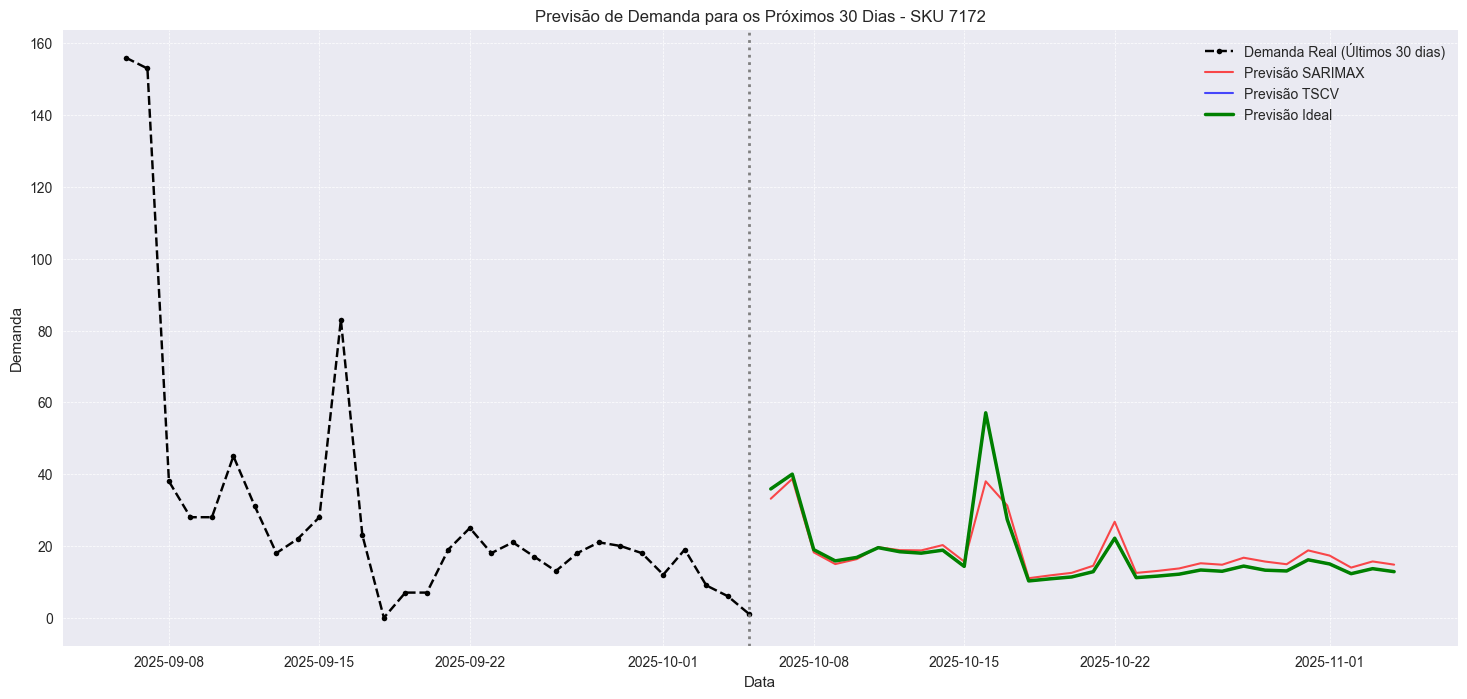


--- Gerando previsão de 30 dias para o SKU: 10036 ---
SKU 10036: Histórico de dados ajustado para começar em 2023-01-01, o primeiro dia com vendas.
--- INICIANDO PREVISÃO PARA OS PRÓXIMOS 30 DIAS (SKU: 10036) ---
Último preço registrado: 38.90 em 2025-10-05
Para os próximos 30 dias, o preço será baseado no mesmo dia 30 dias atrás, ou no último preço se a data não existir.
  Gerando gráfico de previsão futura...
SKU 10036: Histórico de dados ajustado para começar em 2023-01-01, o primeiro dia com vendas.
--- INICIANDO PREVISÃO PARA OS PRÓXIMOS 30 DIAS (SKU: 10036) ---
Último preço registrado: 38.90 em 2025-10-05
Para os próximos 30 dias, o preço será baseado no mesmo dia 30 dias atrás, ou no último preço se a data não existir.
  Gerando gráfico de previsão futura...

Gráfico de previsão salvo em: ../Graficos/previsao_30_dias_sku_10036.png

Gráfico de previsão salvo em: ../Graficos/previsao_30_dias_sku_10036.png


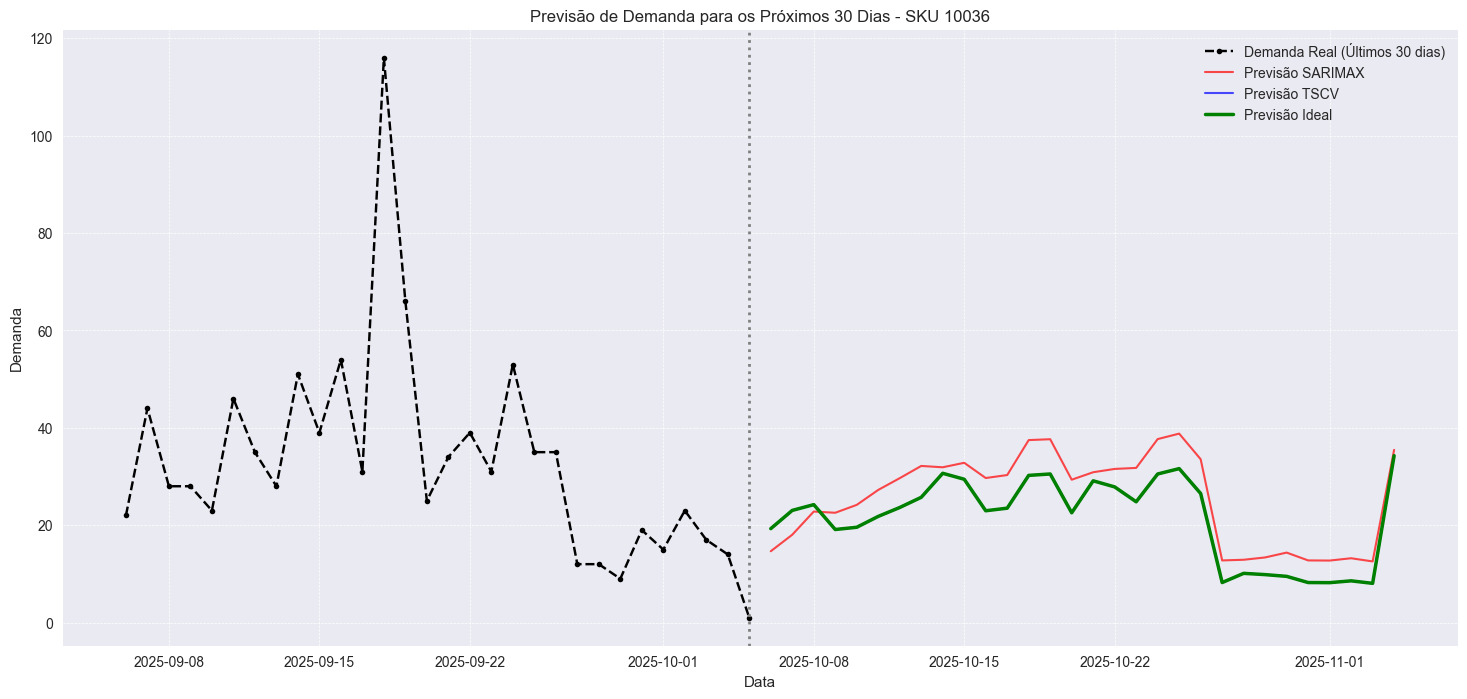


--- Gerando previsão de 30 dias para o SKU: 21120 ---
SKU 21120: Histórico de dados ajustado para começar em 2023-01-02, o primeiro dia com vendas.
--- INICIANDO PREVISÃO PARA OS PRÓXIMOS 30 DIAS (SKU: 21120) ---
Último preço registrado: 54.89 em 2025-10-05
Para os próximos 30 dias, o preço será baseado no mesmo dia 30 dias atrás, ou no último preço se a data não existir.
  Gerando gráfico de previsão futura...
SKU 21120: Histórico de dados ajustado para começar em 2023-01-02, o primeiro dia com vendas.
--- INICIANDO PREVISÃO PARA OS PRÓXIMOS 30 DIAS (SKU: 21120) ---
Último preço registrado: 54.89 em 2025-10-05
Para os próximos 30 dias, o preço será baseado no mesmo dia 30 dias atrás, ou no último preço se a data não existir.
  Gerando gráfico de previsão futura...

Gráfico de previsão salvo em: ../Graficos/previsao_30_dias_sku_21120.png

Gráfico de previsão salvo em: ../Graficos/previsao_30_dias_sku_21120.png


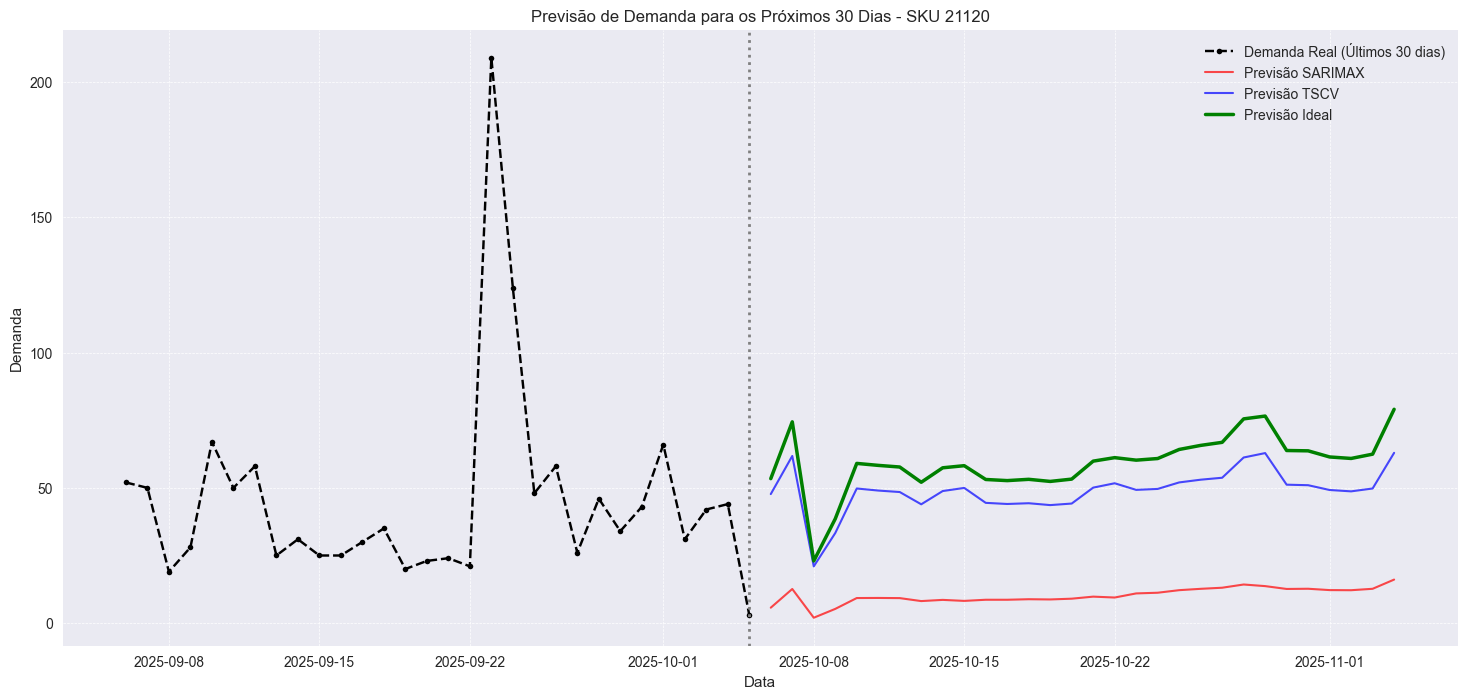


Arquivo de previsões futuras consolidado salvo em: c:\Users\joao.pcarvalho\Desktop\Git Repositórios\Forecast-vendas-e-elasticidade\Resultados\previsoes_futuras_consolidado.csv

Amostra das previsões de 30 dias consolidadas:


,Data,SKU,Preco,promocionado,Log_Preco,Quarta-feira,Terça-feira,previsao_TSCV,previsao_SARIMAX,previsao_total
0,2025-10-06,7172,291.01,0,5.673358,0,0,35.878620,33.152265,35.878620
1,2025-10-07,7172,290.34,0,5.671053,0,1,39.998924,38.674718,39.998924
2,2025-10-08,7172,340.45,0,5.830268,1,0,18.950298,18.214045,18.950298
3,2025-10-09,7172,345.79,0,5.845832,0,0,15.832802,14.945469,15.832802
4,2025-10-10,7172,341.52,0,5.833406,0,0,16.793947,16.326951,16.793947


In [5]:
import os
import sys
import pandas as pd
from IPython.display import display
import joblib
from statsmodels.tsa.statespace.sarimax import SARIMAXResults

current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

from Functions.FNC_Previsoes import prever_demanda_com_modelos_salvos, pred_prox_30_dias
from Functions.FNC_Pro import Base_venda

# --- Definir os caminhos ---
caminho_pasta_modelos = os.path.join(project_root, 'Modelos')
caminho_planilha_precos = os.path.join(project_root, 'Forecast', 'Precos_para_previsoes.xlsx')
caminho_resultados = os.path.join(project_root, 'Resultados')


# --- 1. Previsões com base no arquivo de preços ---
print("--- INICIANDO PREVISÕES COM BASE NO ARQUIVO DE PREÇOS ---")
df_previsoes_salvas = prever_demanda_com_modelos_salvos(
    caminho_pasta_modelos,
    caminho_planilha_precos
)

if not df_previsoes_salvas.empty:
    # Salvar o arquivo consolidado
    caminho_arquivo_consolidado = os.path.join(caminho_resultados, 'previsoes_consolidado.csv')
    df_previsoes_salvas.to_csv(caminho_arquivo_consolidado, index=False, sep=';', decimal=',')
    print(f"\nArquivo de previsões consolidado salvo em: {caminho_arquivo_consolidado}")
    
    print("\nAmostra das previsões geradas a partir do arquivo de preços:")
    display(df_previsoes_salvas.head())


# --- 2. Previsões de 30 dias para o futuro (com gráficos) ---
print("\n\n--- INICIANDO PREVISÕES DE 30 DIAS PARA O FUTURO ---")
try:
    df_precos = pd.read_excel(caminho_planilha_precos)
    skus_para_prever = df_precos['SKU'].astype(str).unique()
    print(f"SKUs encontrados no arquivo de preços para gerar previsões futuras: {list(skus_para_prever)}")
except FileNotFoundError:
    print(f"ERRO: Arquivo de preços não encontrado em '{caminho_planilha_precos}'")
    skus_para_prever = []

previsoes_futuras_consolidadas = []
if skus_para_prever.any():
    for sku in skus_para_prever:
        print(f"\n--- Gerando previsão de 30 dias para o SKU: {sku} ---")
        
        caminho_modelo_tscv = os.path.join(caminho_pasta_modelos, f'modelo_tscv_{sku}.joblib')
        caminho_modelo_sarimax = os.path.join(caminho_pasta_modelos, f'modelo_sarimax_{sku}.pkl')

        if not os.path.exists(caminho_modelo_tscv) or not os.path.exists(caminho_modelo_sarimax):
            print(f"  AVISO: Modelos para o SKU {sku} não encontrados. Pulando.")
            continue
        
        modelo_tscv = joblib.load(caminho_modelo_tscv)
        modelo_sarimax = SARIMAXResults.load(caminho_modelo_sarimax)
        Venda = Base_venda(sku)
        
        if Venda.empty:
            print(f"  AVISO: Não foi possível carregar o histórico de vendas para o SKU {sku}. Pulando.")
            continue

        df_previsao_futura = pred_prox_30_dias(
            modelo_tscv,
            modelo_sarimax,
            Venda,
            sku,
            X_cols_tscv=['Log_Preco', 'Quarta-feira', 'Terça-feira', 'promocionado']
        )
        previsoes_futuras_consolidadas.append(df_previsao_futura)

if previsoes_futuras_consolidadas:
    df_previsoes_finais = pd.concat(previsoes_futuras_consolidadas, ignore_index=True)
    
    # Salvar o arquivo consolidado de previsões futuras
    caminho_futuro_consolidado = os.path.join(caminho_resultados, 'previsoes_futuras_consolidado.csv')
    df_previsoes_finais.to_csv(caminho_futuro_consolidado, index=False, sep=';', decimal=',')
    print(f"\nArquivo de previsões futuras consolidado salvo em: {caminho_futuro_consolidado}")

    print("\nAmostra das previsões de 30 dias consolidadas:")
    display(df_previsoes_finais.head())
else:
    print("\nNenhuma previsão de 30 dias foi gerada.")

### Subindo resultados consolidados no BQ

In [6]:
resultados_consolidados.to_csv('Resultados_Elasticidade.csv',index=False)


from google.cloud import storage


bucket_name = 'epoca-storage'

destination_blob_name1 = 'senior-estoque/Resultados Modelos/Forecast/Resultados_Elasticidade.csv'
storage_client = storage.Client()
bucket = storage_client.bucket(bucket_name)
blob = bucket.blob(destination_blob_name1)
blob.upload_from_filename('Resultados_Elasticidade.csv')

print("Arquivo 'Resultados_Elasticidade.csv' enviado com sucesso para o bucket do Google Cloud Storage.")

Arquivo 'Resultados_Elasticidade.csv' enviado com sucesso para o bucket do Google Cloud Storage.
